# Presets 

In [1]:
import torch
torch.__version__

'2.1.2'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.version.cuda

(device(type='cuda'), '12.1')

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

if torch.cuda.is_available():
    if not os.environ.get('CUBLAS_WORKSPACE_CONFIG', False):
        os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
else:
    if os.environ.get('CUBLAS_WORKSPACE_CONFIG', False):
        del os.environ['CUBLAS_WORKSPACE_CONFIG']

os.environ["device"] = str(device)
os.environ.get('CUBLAS_WORKSPACE_CONFIG', None)

':4096:8'

In [4]:
torch.set_default_device(device)
torch.set_default_dtype(torch.float)
torch.backends.cudnn.benchmark = torch.cuda.is_available()
torch.backends.cudnn.deterministic = torch.cuda.is_available()
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.enabled = torch.cuda.is_available()

In [ ]:
import numpy as np
import random

SEED = 3407 #torch.seed()
os.environ["SEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed()
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator(device=device)
g.manual_seed(SEED)

SEED, g.device, g.initial_seed()

(3407, device(type='cuda'), 3407)

# Loading Data

In [ ]:
from pathlib import Path

# input
BASE = Path.cwd() 
MEDIA = BASE / "data"  / "mediapipe"
DATA = BASE / "data" / "data.csv"
TRAIN = BASE / "data" / "train.csv"
TEST = BASE / "data" / "test.csv"

# output
ACCURACY = BASE / "results" / "accuracy"
CM = BASE / "results" / "confusion_matrices"
LOSS = BASE / "results" / "loss"

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd 

df = pd.read_csv(DATA)
X_train, X_test = train_test_split(df, random_state=SEED, test_size=0.2, shuffle=True)
X_train.head()

,filename,bending forward,heels lifting,knees caving,no depth,olympic squat,powerlifting squat,toes lifting
209,recording_05042023_140245,0.0,1.0,0.0,0.0,0.0,0.0,0.0
154,recording_05042023_124455,0.0,0.0,0.0,1.0,0.0,0.0,0.0
741,recording_13042023_160701,0.0,1.0,0.0,0.0,0.0,0.0,0.0
485,recording_11042023_120136,0.0,0.0,0.0,0.0,1.0,0.0,0.0
790,recording_13042023_161849,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
labels = [col for col in X_train.columns if col != "filename"]

In [ ]:
X_train.to_csv(TRAIN, index=False)
X_test.to_csv(TEST, index=False)

# Data Preprocessing

In [ ]:
from utils.dataset import SquatDataset

train_dataset = SquatDataset(csv_file=TRAIN, root_dir=MEDIA, device=device)
test_dataset = SquatDataset(csv_file=TEST, root_dir=MEDIA, device=device)

len(train_dataset), len(test_dataset)

(1058, 265)

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

def seed_worker(worker_id):
    worker_seed = torch.cuda.initial_seed() if torch.cuda.is_available()\
                    else torch.initial_seed()

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                              num_workers=0, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Training

In [83]:
from models.rnn_with_attention import RNNAttModel

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model = RNNAttModel(input_dim=57, output_dim=7).to(device)

# from torchinfo import summary 
# summary(model, input_size=(1, 300, 57))

if model.__class__.__name__ in ["CLSTMModel", "CLSTMAttModel", "CGRUModel", "CGRUAttModel", "TCNGRUAttModel"]:
    torch.use_deterministic_algorithms(False)
else:
    torch.use_deterministic_algorithms(True)
model

RNNAttModel(
  (batch_norm): BatchNorm1d(300, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (rnn): RNN(57, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (dense): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=7, bias=True)
  )
  (attention): SelfAttention(
    (luong_w): Linear(in_features=64, out_features=64, bias=False)
    (softmax_normalizer): Softmax(dim=-1)
    (w_c): Linear(in_features=128, out_features=64, bias=False)
    (tanh): Tanh()
  )
)

In [ ]:
from tqdm.auto import tqdm
from torch import nn
from utils.training import train_step, test_step
from utils.checkpoint import Checkpoint
from utils.metrics import CategoricalAccuracy

train_accuracy_list, test_accuracy_list = [], []
train_loss_list, test_loss_list = [], []

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

os.makedirs("artifacts", exist_ok=True)
checker = Checkpoint(path="artifacts")
error = nn.CrossEntropyLoss()
accuaracy = CategoricalAccuracy(k=1).cat_acc
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7) 

epochs = range(1000)

for epoch in tqdm(epochs):
    train_acc, train_loss = train_step(model=model, dataloader=train_dataloader, loss_function=error, 
                                        optimizer=optimizer, device=device, accuracy_fn=accuaracy)
    test_acc, test_loss = test_step(model=model, dataloader=test_dataloader, loss_function=error, 
                                    device=device, accuracy_fn=accuaracy)
    train_accuracy_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)
    benchmark = checker.save_best(score=test_acc, loss=test_loss, \
                      model=model, optimizer=optimizer, \
                      epoch=epoch, seed=SEED)

    if (epoch+1)%10 == 0:
        print(f"Epoch: {str(epoch+1).zfill(4)} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Benchmark: {benchmark:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0010 | Train loss: 1.8492 | Train acc: 0.2680 | Test loss: 1.6554 | Test acc: 0.3388 | Benchmark: 0.3550
Epoch: 0020 | Train loss: 1.7918 | Train acc: 0.2666 | Test loss: 1.5694 | Test acc: 0.3889 | Benchmark: 0.3889
Epoch: 0030 | Train loss: 1.7665 | Train acc: 0.2785 | Test loss: 1.6007 | Test acc: 0.4097 | Benchmark: 0.4097
Epoch: 0040 | Train loss: 1.7248 | Train acc: 0.2862 | Test loss: 1.5943 | Test acc: 0.4175 | Benchmark: 0.4175
Epoch: 0050 | Train loss: 1.7279 | Train acc: 0.2914 | Test loss: 1.5497 | Test acc: 0.3519 | Benchmark: 0.4468
Epoch: 0060 | Train loss: 1.6899 | Train acc: 0.3050 | Test loss: 1.5268 | Test acc: 0.3883 | Benchmark: 0.4468
Epoch: 0070 | Train loss: 1.6626 | Train acc: 0.3205 | Test loss: 1.4800 | Test acc: 0.4592 | Benchmark: 0.4592
Epoch: 0080 | Train loss: 1.6702 | Train acc: 0.3178 | Test loss: 1.5761 | Test acc: 0.3090 | Benchmark: 0.4670
Epoch: 0090 | Train loss: 1.6783 | Train acc: 0.3267 | Test loss: 1.5581 | Test acc: 0.3909 | Benchmark:

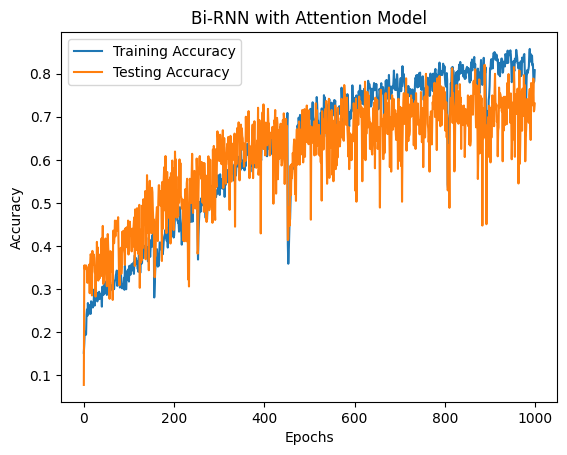

In [ ]:
import matplotlib.pyplot as plt

if "Att" in model.__class__.__name__[:-5]:
    model_name = f"Bi-{model.__class__.__name__[:-8]} with Attention Model"
else:
    model_name = f"Bi-{model.__class__.__name__[:-5]} Model"
plt.plot(epochs, train_accuracy_list)
plt.plot(epochs, test_accuracy_list)
# plt.axvline(checkpoint['epoch'], linestyle='dashed', color='g')
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(model_name)
plt.savefig(ACCURACY / f'{model_name}.png', bbox_inches='tight', dpi=500)
plt.show()

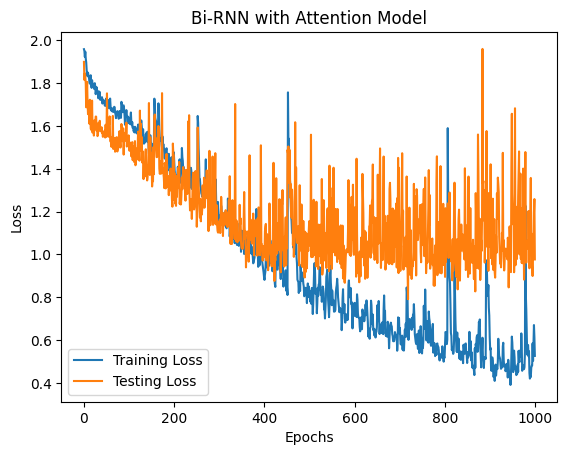

In [ ]:
test_loss_list = [i.item() for i in test_loss_list]
plt.plot(epochs, train_loss_list)
plt.plot(epochs, test_loss_list)
plt.legend(["Training Loss", "Testing Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(model_name)
plt.savefig(LOSS / f'{model_name}.png', bbox_inches='tight', dpi=500)
plt.show()

# Inferencing

In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model = RNNAttModel(input_dim=57, output_dim=7).to(device)
checkpoint = torch.load(os.path.join("artifacts", f"{model.__class__.__name__}.pt"))
model.load_state_dict(checkpoint["model"])
print(f"Best {model.__class__.__name__} model accuracy is {checkpoint['accuracy']:.4f} attained at epoch #{checkpoint['epoch']}")

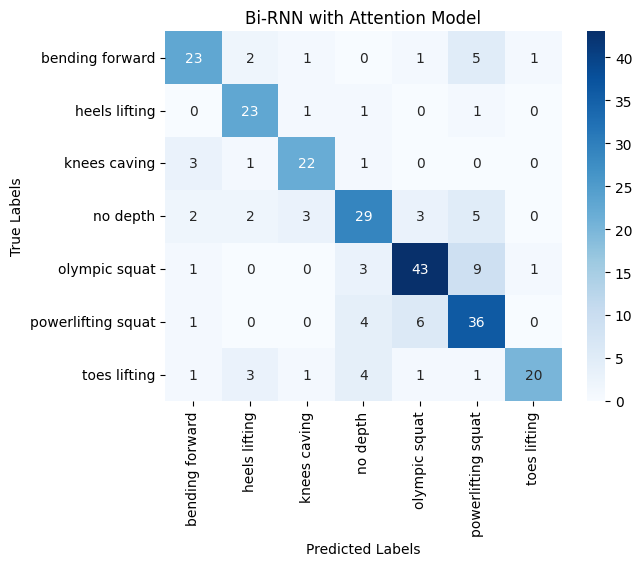

In [ ]:
from sklearn.metrics import confusion_matrix
from utils.class_inference import eval_step
import seaborn as sns

t, p = eval_step(model, test_dataloader, device)
cf_matrix = confusion_matrix(t, p)
plt.title(model_name)
cm_map = sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
cm_map.set(xlabel="Predicted Labels", ylabel="True Labels")
figure = cm_map.get_figure()    
figure.savefig(CM / f'{model_name}.png', dpi=500, bbox_inches='tight')